# Neural Networks, Part 1: Linear Layers

In the "Supervised Learning" and "Unsupervised Learning" notebooks, we covered some of the most common machine learning tasks and the techniques used to accomplish these tasks. As we saw, there's much more to a machine learning system than the learning algorithm: you have to know how to prepare a dataset, how to select an algorithm and its hyperparameters, and how to traing and evaluate a model. And knowing how to visualize things along the way certainly doesn't hurt either. None of these concepts are going away just because we're about to study neural networks; in fact, all of these machine learning concepts _form the basis_ on which we can understand and appreciate the capabilities of neural networks.

There has been a lot of buzz surrounding __neural networks__ these days. Everyone has heard something about neural networks, and almost everyone (it seems like) is trying to use them some way or another. It may surprise you that only a few decades ago, neural networks weren't really considered to be useful for anything, and were generally scoffed at. It was the emergence of __big data__ and __graphics processing units (GPUs)__ which brought neural networks to the forefront as a tool which could perform tasks like image classification at a shocking new level of accuracy.

Some people see neural networks as magic boxes that work for magical reasons; other people see neural networks as black boxes that can't be trusted. In this notebook, we'll look at the building blocks of neural networks, and then we'll build one. We'll show you that neural networks aren't as mysterious as they may seem -- they're just another type of machine learning algorithm.

_Note: some code segments have TODO comments in them. These comments are optional exercises for you to modify the code in a useful way, however they are not meant to be restrictive. Feel free to modify the code in this notebook any way you like; it's a great way to practice your coding skills._

## Getting Started

You should have your own Anaconda virtual environment with all of the necessary Python modules installed. Additionally, this notebook is the first one which uses tensorflow, so __you need an NVIDIA GPU to use this notebook__ (unless you also installed the CPU version of tensorflow (but you probably didn't)). You can check by trying to import them:

In [17]:
import ipywidgets
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
import sklearn.metrics

## The MNIST Dataset

So far we've only been using toy datasets from scikit-learn and seaborn. Now it's time to introduce you to a _real_ dataset; it's time to start using big data. The MNIST dataset is considered the "Hello World" of big datasets in the machine learning / deep learning community. It is an image dataset of handwritten digits, like the digits dataset that we considered previously, except that this dataset contains 70,000 28x28 images:

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("X_train: %s" % str(X_train.shape))
print("y_train: %s" % str(y_train.shape))
print("X_test: %s" % str(X_test.shape))
print("y_test: %s" % str(y_test.shape))

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


These sizes may seem large and scary, but remember that MNIST is _tiny_ compared to most modern datasets, which can contain hundreds of thousands or even millions of samples. Fortunately, MNIST has a pre-defined training set and test set, so we won't have to do create these sets ourselves as with the toy datasets. Before we get started, let's also load a few samples images from MNIST:

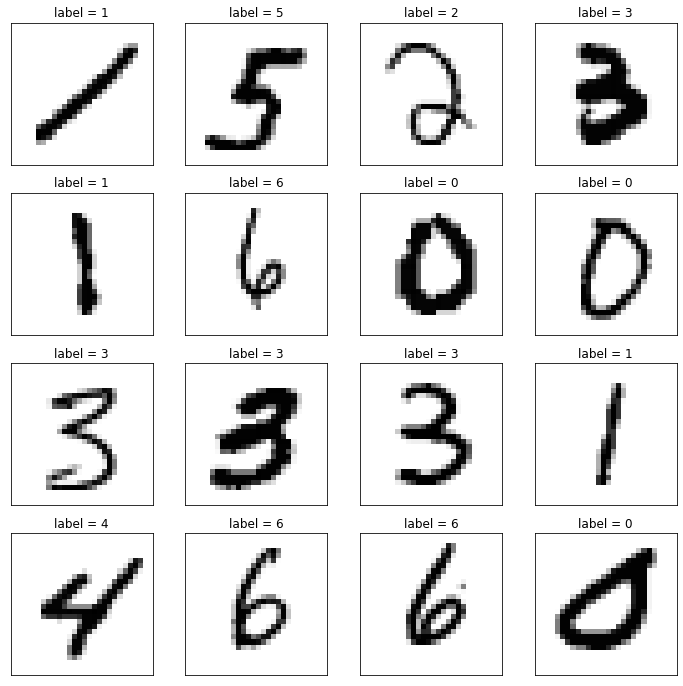

In [44]:
# define the size of the grid
rows = 4
cols = 4

# select several samples from MNIST at random
indices = np.random.choice(np.arange(len(X_train)), rows * cols)

# plot the images in a grid
plt.figure(figsize=(3 * cols, 3 * rows))

for i in range(rows * cols):
    index = indices[i]
    
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(255-X_train[index], cmap="gray")
    plt.title("label = %d" % y_train[index])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# TODO: can you plot the negative images, that is, as black on a white background?


## The Neuron

<img src="http://cs231n.github.io/assets/nn1/neuron_model.jpeg" alt="neuron" width=400/>

The figure above shows the most fundamental unit of a neural network, the __neuron__. This unit is essentially what gives neural networks the ability to learn complex datasets. The input to the unit is a vector $\vec{x} = \{x_1, x_2, ..., x_n\}$. These values are like the features (dimensions) of a dataset, which we have been using since the first notebook. The unit itself consists of a vector $\vec{w} = \{w_1, w_2, ..., w_3\}$ whose values are the __weights__, with an additional value $b$ which is the __bias__. Finally, the output of the unit is the weighted sum of the input (including the bias), followed by an __activation function__. Thus, the mathematical definition of the neuron is as follows:

$$a = \sigma(\vec{w} \cdot \vec{x} + b)$$

__Question__: This model is actually identical to logistic regression; can you identify what model you get if you remove the activation function? _Hint: it's a model that we studied in the "Supervised Learning" notebook._

### Activation Functions: The Secret Sauce of Success

The key ingredient of the perceptron which makes it so useful is the activation function. This function is typically a nonlinear function whose output range is something small such as $[0, 1]$. One of the earliest examples of an activation function is the __sigmoid__ function:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Here's an interactive plot to give you some intuition for how the sigmoid behaves:

In [6]:
def sigmoid(x, a=1, b=1):
    # compute sigmoid (with additional parameters a and b)
    return 1 / (1 + np.exp(-(x - a)) / (b + 0.1))

def plot_sigmoid(a, b):
    # compute sigmoid function for an input range
    x = np.linspace(-10, 10, num=200)
    sigma = sigmoid(x, a, b)

    # plot sigmoid function
    plt.figure(figsize=(6, 6))
    plt.plot(x, sigma)
    plt.xlim(x.min(), x.max())
    plt.title("The Sigmoid Function")
    plt.ylabel("Output")
    plt.xlabel("Input")
    plt.show()

# create a plot with sliders for the parameters a and b
a_slider = ipywidgets.FloatSlider(min=-5, value=0, max=10, step=0.2)
b_slider = ipywidgets.IntSlider(min=-5, value=0, max=10, step=1)

ipywidgets.interactive(plot_sigmoid, a=a_slider, b=b_slider)

interactive(children=(FloatSlider(value=0.0, description='a', max=10.0, min=-5.0, step=0.2), IntSlider(value=0…

The activation function has two purposes in a neuron:

1. Apply a nonlinear transformation to the weighted sum.
2. "Squash" the weighted sum, which may be large, into a small range of possible values.

The __nonlinearity__ property is especially crucial because __it allows the neuron to model nonlinear relationships__, and, as we will see later, it allows us to scale our neural network to be as large as we need it to be for a given task. Interestingly enough, the neuron model can work with all sorts of nonlinear functions, although some functions work better than others.

The __squashing__ (or __saturation__) property actually comes from the neuron's original conception as a model of a biological neuron. The idea is that a biological neuron essentially behaves like a switch with a smooth transition in the middle, so even if the weighted sum of the inputs is extremely high or extremely low, the final output of the neuron will still be a simple "on" or "off". That being said, not all activation functions adhere to this squashing property as strictly as sigmoid, so this property is really more of a guideline rather than a necessity.

## The Multilayer Perceptron

The neuron is the fundamental building block of a neural network. The process of constructing a neural network out of neurons is fairly straightforward: we first construct a __layer__ as an array of neurons, and then we construct a __network__ as a sequence of layers. This architecture is described in the figure below:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="neural-net" width=500/>

This type of neural network is called a __multilayer perceptron (MLP)__ (or __feed-forward neural network__). The white circles in the figure are invididual neurons (we'll call them __units__ from here on out), and the colored rectangles are layers. There are three types of layers in the figure: __input layers__, __output layers__ and __hidden layers__. Hidden layers and output layers are really the same, the output layer is just the last layer in the network. The input layer is really just a placeholder for the input features (i.e. the white circles in the input layer are just input features, not neurons). We would call the network in this figure a "3-layer neural network" (again, we don't count the input layer since it's just a placeholder).

The defining aspect of an MLP is how each layer is connected: each unit in a layer receives an input from every unit in the previous layer. A layer with this kind of input connections is called a __fully-connected layer__ (or __dense layer__). Remember that each input to a unit has a weight; just as we represented the set of weights for a single unit as a vector, we can represent all of the input connections to a layer as a __weight matrix__ $W$. This matrix has size $n \times m$, where $m$ is the number of units in the previous layer and $n$ is the number of units in the given layer, and the $i^{th}$ row is just the weight vector for the $i^{th}$ unit in the given layer. Using this weight matrix we can actually compute the output of every unit in a layer with a single equation:

$$\vec{a} = \sigma(W \vec{x} + \vec{b})$$

Where $\vec{a}$ is a vector of the unit outputs, and we assume that all of the units use the same activation function. Since we're using a lot of vectors and matrices now, here are their sizes:

$$\vec{a}, \vec{b} \in \mathbb{R}^{n}; W \in \mathbb{R}^{n \times m}; \vec{x} \in \mathbb{R}^{m}$$

Now that we can construct a layer, compute the output of a layer, and connect layers in sequence, the last step is to compute the output of an entire network from input layer to output layer. This step is actually very simple: the output $\vec{a}$ of one layer becomes the input $\vec{x}$ to the next layer. For example, if we consider the 3-layer network from the figure, we can compute the output $\vec{a}_{out}$ of the network as follows:

$$f_i(\vec{x}) = \sigma(W_i \vec{x} + \vec{b}_i)$$

$$\vec{a}_{out} = f_{net}(\vec{x}) = f_3(f_2(f_1(\vec{x})))$$

This computation is also called the __forward pass__ of a network.

As you can imagine, there really is no limit to the possible size of the network -- you can have as many fully-connected layers as you want, you can have as many units per layer as you want, and you can size each layer indepedently. As a result, the MLP is an extremely general model, meaning that it can model all kinds of functions using a series of matrix transformations and nonlinear activations. This idea is called the __universal approximation theorem__, because the idea is that the MLP is able to _approximate_ any kind of function. Whether the MLP can learn any function _from data_... well, you just have to try it and see.

The __network architecture__ -- that is, the number and respective sizes of each layer, and the choice of activation function -- is a major hyperparameter of a neural network. In fact, we've really brought hyperparameters to a new level here, because the architecture could be comprised of an entire list of hyperparameters! This freedom is good because it makes neural networks extremely versatile, but it is also very daunting if we don't know how to pick the right settings for the task. You'll be experimenting with network architecture for your assignment, but for now let's look at some basic applications of neural networks.

## Supervised Learning: MLP

Let's build a neural network to perform classification on the MNIST dataset. As it turns out, scikit-learn actually has an `MLPClassifier`, but we need something that will run on a GPU -- trust me, we're going to need the extra compute power later on. From now on we're going to use two Python libraries, __Tensorflow__ and __Keras__. Tensorflow is a GPU-accelerated framework for creating and running neural networks, and Keras is a thin wrapper over Tensorflow which provides a much simpler interface (Keras also supports other _backends_ aside from Tensorflow). In short, we will use Keras, but just know that Tensorflow is doing all of the hard work behind the scenes. Now let's make a network:

In [7]:
# create a 3-layer neural network
mlp = keras.models.Sequential()
mlp.add(keras.layers.Dense(units=1024, activation="sigmoid", input_shape=(784,))) 
mlp.add(keras.layers.Dense(units=1024, activation="sigmoid"))
mlp.add(keras.layers.Dense(units=10, activation="softmax"))

Wow. That was stupid easy. Wasn't that easy? Defining a network couldn't be more simple. For each layer, you define the number of units and the activation function, and then you add the layer to the network. You don't have to do anything with vectors or matrices, it's all just hyperparameters.

Two aspects of this network are actually derived from the dataset: the `input_shape` parameter and the size of the output layer. First, images in the MNIST dataset are 28x28 so they have $28 \times 28 = 784$ features -- we always specify the number of input features to the first layer in a network. Secondly, the MNIST dataset has 10 classes corresponding to the 10 digits -- the output layer always has the same number of units as the number of classes (unless we're doing __binary classification__, in which case we only need one unit).

So... what exactly is the output of the neural network? What does it mean? Well, since we have an output unit for each class, we say that each output unit represents a "score" for a particular class. In other words, the output for class $j$ measures how strongly the network "believes" that a given sample belongs to that class. We also introduce an activation function called __softmax__, which normalizes the outputs to look like a probability distribution. Here's the math:

$$\sigma(\vec{z})_j = \frac{e^{z_j}}{\Sigma_{k=1}^{K} e^{z_k}}, j = 1, ..., K$$

In this equation, the softmax function takes a vector $\vec{z}$ of the raw outputs (also called the __logits__) and produces a vector which has two properties: (1) each value is between $[0, 1]$, and (2) the values sum to 1. Here's a quick code example:

In [8]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

# create a vector of raw outputs
z = 10 + 5 * np.random.randn(10)

# compute the normalized output
z_out = softmax(z)

# print results
print("z:    ", "".join(["%8.2f" % (z_i) for z_i in z]))
print("z_out:", "".join(["%8.2f" % (z_i) for z_i in z_out]))
print()
print("sum(z_out) = %g" % (sum(z_out)))

z:         7.21    1.42   11.25   16.87   10.97    8.08   12.09    3.36   11.13    8.29
z_out:     0.00    0.00    0.00    0.98    0.00    0.00    0.01    0.00    0.00    0.00

sum(z_out) = 1


Run the above code multiple times to see different examples. As you can see, the outputs of the softmax always sum to 1. Constraining our output to look like a probability distribution is useful because it makes our results more __interpretable__. For example, if the softmax output for class $j$ is 0.7, then we can say that the network is "70% confident" that the given sample belongs to class $j$. The "final answer" of the network, then, is the class with the highest output confidence.

Understanding the softmax function is the last step we need to establish how to train the network. In the "Supervised Learning" notebook, we would train a classifier to predict the category of a sample by giving it the "right answer" -- the ground truth label. Since the neural network can output not only a category but also the underlying probability distribution, we're going to train the network to not only have a high confidence in the right answer but also a low confidence in all of the wrong answers. To do this, we'll have to convert our labels to be __one-hot labels__:

In [9]:
# sample some labels from MNIST
y = np.random.choice(y_train, 5)

# convert labels to one-hot labels
y_categorical = keras.utils.to_categorical(y, num_classes=10)

# print results
print("y:\n", y)
print()
print("y_categorical:\n", y_categorical)

y:
 [4 6 4 1 2]

y_categorical:
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


Note that the one-hot labels have the same structure and properties as the softmax output. Technically, they are like probability distributions; each one-hot label represents 100% certainty in a particular class. Using one-hot labels, we can train the network to not only be correct, but to be _confident_, which should make it more robust.

The remaining aspects of the network are specified when we "compile" the model in Keras. In particular, we specify:
- the __loss function__: the function that quantifies the amount of error in the network
- the __optimizer__: the algorithm that attempts to minimize the loss function during training
- the __metrics__: the methods for evaluating the network during testing

Although the first two may look unfamiliar, we've actually used all of these things before! The concept of a loss function and an optimizer to minimize the loss is present in many supervised learning algorithms, such as linear regression and logistic regression. We just didn't explore them in detail at the time. There are a wide variety of loss functions and optimizers, and some of them can be rather involved mathematically. A good way to start is to study the options available to you in Keras and try them yourself.

In the code below, we use the __cross-entropy__ loss function and the __stochastic gradient descent (SGD)__ optimizer. Both of these choices are typical for the task that we are doing; however, there are alternatives for both choices. Feel free to experiment with the other [loss functions](https://keras.io/losses/) and [optimizers](https://keras.io/optimizers/) available in Keras.

In [10]:
# compile the model
mlp.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# print a summary of the model
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
_________________________________________________________________


Once we define all of the layers for the model and compile it, we can print a summary which lists each layer. Notice also that the summary includes the number of __parameters__. Remember the variable $\vec{\theta}$ from our super-simplified mathematical model, and how we said that $\vec{\theta}$ could be literally anything? We weren't kidding: in the model we just created, $\vec{\theta}$ is essentially a vector of _millions of variables_! And this network is _tiny_!

Now it's time to train our model. We already mentioned how we're going to convert our labels to one-hot labels. We also need to flatten our training and test images from 28x28 matrices into 784-dimensional vectors; fortunately, numpy can do this for us without much hassle. During training, we split the training set into evenly-sized chunks called __batches__ and then we feed each batch through the network. For each batch, the network predicts a class for each sample, computes the total amount of error using the loss function, and then updates its weights using the optimizer. When the network has processed every batch in the training set, it has completed a single __epoch__. We can repeat this process as many times as we want; the batches are determined randomly so they will be different for each epoch.

In [11]:
# reshape the training and test images into vectors
X_flat_train = X_train.astype("float32") / 255.
X_flat_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

X_flat_test = X_test.astype("float32") / 255.
X_flat_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# convert the training and test labels into one-hot labels
y_cate_train = keras.utils.to_categorical(y_train, num_classes=10)
y_cate_test = keras.utils.to_categorical(y_test, num_classes=10)

# train the model
history = mlp.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)




Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 64us/step - loss: 1.9804 - acc: 0.5310 - val_loss: 1.6653 - val_acc: 0.7740
Epoch 2/50
54000/54000 [==============================] - 0s 6us/step - loss: 1.4687 - acc: 0.7733 - val_loss: 1.2333 - val_acc: 0.8383
Epoch 3/50
54000/54000 [==============================] - 0s 6us/step - loss: 1.1272 - acc: 0.8201 - val_loss: 0.9450 - val_acc: 0.8732
Epoch 4/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.9050 - acc: 0.8431 - val_loss: 0.7630 - val_acc: 0.8842
Epoch 5/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.7601 - acc: 0.8573 - val_loss: 0.6430 - val_acc: 0.8907
Epoch 6/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.6615 - acc: 0.8665 - val_loss: 0.5615 - val_acc: 0.8980
Epoch 7/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.5911 - acc: 0.8754 - val_loss: 0.5022 - val_acc: 0.903

Congratulations, you just trained your first neural network.

But did it do well? That is, did it learn how to classify the MNIST images? One way that we can try to answer this question is to plot the accuracy and the loss over time. When we train a model, Keras records these values at the end of each epoch and returns them in a "history" object. Let's take a look:

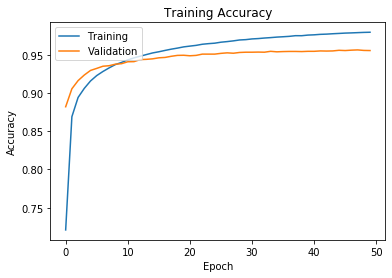

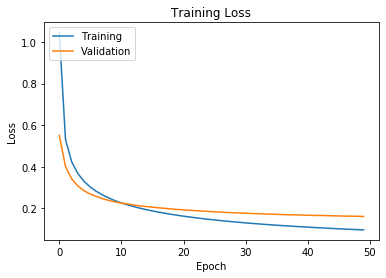

In [53]:
def plot_acc():
# plot the training accuracy
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.title("Training Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")
    plt.show()
    
    # plot the training loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Training Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")
    plt.show()
plot_acc()

You should see that the accuracy increases and level offs, and that the loss function decreases and levels off (and you should see that training and validation are similar). This behavior is one sign that the network learned well. To contrast, if the loss function hadn't decreased or if it had bounced up and down like a sine wave, it would probably mean that the network didn't learn from the training set very well.

Visualizing the training process is the first check; the second check is the actual evaluation. As with other supervised learning algorithms, we evaluate the network with a test set which contains data that the network has not seen. We already defined our evaluation metrics when we compiled the model; since this network is doing classification, we'll just keep using accuracy:

In [52]:
def print_score():
    # evaluate the model on the test set
    scores = mlp.evaluate(x=X_flat_test, y=y_cate_test) 

# print results
    for name, score in zip(mlp.metrics_names, scores):
        print("%s: %g" % (name, score))
print_score()

10000/10000 [==============================] - 0s 25us/step
loss: 0.191378
acc: 0.9433


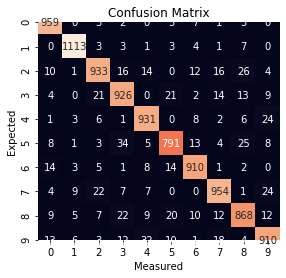

In [20]:
# get the raw predictions of the network on the test set
y_cate_pred = mlp.predict(X_flat_test)

# convert the one-hot encoded output to class indexes
y_pred = np.argmax(y_cate_pred, axis=1)

# TODO: create a confusion matrix from the class predictions (refer to supervised learning notebook)
classes = [str(i) for i in range(10)]


cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# plot a heatmap of the confusion matrix
sns.heatmap(cnf_matrix, annot=True, fmt="d", cbar=False, square=True, xticklabels=classes, yticklabels=classes)
plt.ylabel("Expected")
plt.xlabel("Measured")
plt.title("Confusion Matrix")
plt.show()

You should get around 90% accuracy. So it looks like we have some room to improve, and there are a lot of things we can change: the number of layers, the size of layers, the loss function, optimizer, number of epochs, batch size... where do we even begin?! The easiest thing we can do is to train the network more, that is, increase the number of epochs. However, the network will only benefit so much from more training -- beyond a certain point, more training will not improve accuracy, and in fact it may cause overfitting, which will lead to _lower_ test accuracy. Another good option is to change the optimizer, since SGD is an older algorithm and there exist many newer ones that tend to give better results. The third major option is to change the network architecture, which you will be doing in the assignment.

## Unsupervised Learning: The Autoencoder

Neural networks have definitely shown their worth as supervised learning algorithms. You may be wondering if we can also use neural networks for unsupervised learning. The answer is: basically yes. As it turns out, one of the earliest examples of a neural network was a network that simply learned to reconstruct its input data -- this type of network is called an __autoencoder__. Why would we ever want to train a network to spit out what goes into it? The value of the autoencoder lies in what it learns in the middle of the reconstruction process:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png" alt="autoencoder" width=400/>

The autoencoder isn't allowed to simply take the input and return it as the output -- it has to "encode" the input into a smaller representation, and then "decode" the representation to create the original input. This smaller representation that the autoencoder learns can be very useful to us. In fact, the encoder portion of an autoencoder is essentially doing the same thing as PCA, except that it uses the trained layers to perform the dimensionality reduction instead of principal components.

There are many other types of autoencoders for more specialized tasks, such as __denoising autoencoders__ for noise removal and __variational autoencoders__ for density estimation, but for now we're just going to train a basic autoencoder in Keras to reconstruct images from the MNIST dataset. The process is largely the same, we essentially replace the softmax classifier at the end of the MLP with a decoder network, and instead of using the labels as labels, we use the data as labels!

In [21]:
# create a 4-layer autoencoder (3 hidden layers)
ae = keras.models.Sequential()

# encoder
ae.add(keras.layers.Dense(units=512, activation="relu", input_shape=(784,))) 
ae.add(keras.layers.Dense(units=32, activation="relu"))

# decoder
ae.add(keras.layers.Dense(units=512, activation="relu"))
ae.add(keras.layers.Dense(units=784, activation="sigmoid"))

ae.compile(optimizer="adadelta", loss="binary_crossentropy")

# print model summary
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 837,424
Trainable params: 837,424
Non-trainable params: 0
_________________________________________________________________


In [23]:
# reshape the training and test images into vectors
X_flat_train = X_train.astype("float32") / 255.
X_flat_train = X_flat_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

X_flat_test = X_test.astype("float32") / 255.
X_flat_test = X_flat_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# train the model
history = ae.fit(x=X_flat_train, y=X_flat_train, batch_size=500, epochs=50, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 15us/step - loss: 0.3747 - val_loss: 0.2692
Epoch 2/50
54000/54000 [==============================] - 0s 9us/step - loss: 0.2651 - val_loss: 0.2584
Epoch 3/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.2495 - val_loss: 0.2375
Epoch 4/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.2301 - val_loss: 0.2208
Epoch 5/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.2128 - val_loss: 0.2038
Epoch 6/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.1991 - val_loss: 0.1925
Epoch 7/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.1894 - val_loss: 0.1847
Epoch 8/50
54000/54000 [==============================] - 0s 8us/step - loss: 0.1818 - val_loss: 0.1775
Epoch 9/50
54000/54000 [==============================] - 0s 7us/step - loss: 0.1763 - val_loss: 0.1719
Epoch 10/50
54

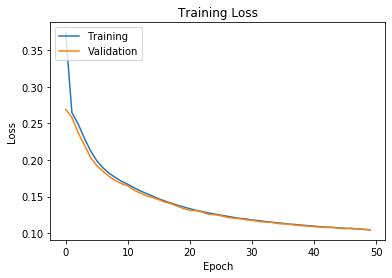

In [24]:
# plot the training loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

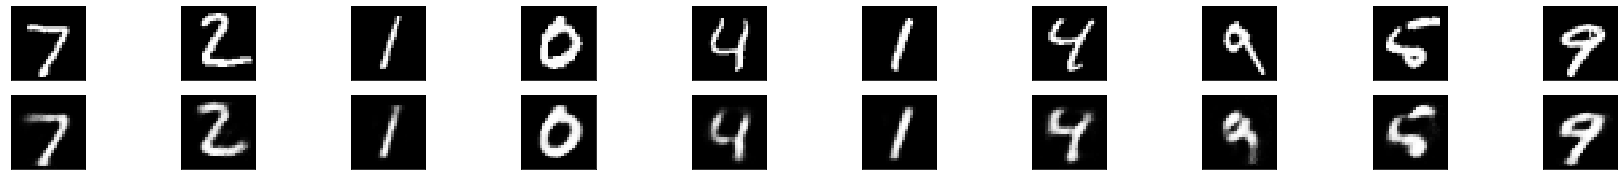

In [25]:
# reconstruct test images with the trained autoencoder
X_reconstructed = ae.predict(X_flat_test)

# sample some test images for visualization
num_images = 10
indices = np.random.choice(np.arange(len(X_flat_test)), num_images)

# plot each sample image and its reconstructed counterpart
plt.figure(figsize=(3 * num_images, 3))

for i in range(num_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(X_flat_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

After training, the autoencoder should be able to reconstruct the original images, maybe with some noise. As with the image classifier, the same choices apply if we want to improve the fidelity of the autoencoder; primarily, train it for longer, swap out components, or add more layers.

## Assignment: Pick Your Architecture

In this notebook we've shown you all of the essential features for creating neural networks in Keras. If you want to study these features in-depth, we refer you to the [Keras documentation](https://keras.io/). Also, if you'd like to learn more about neural networks in general, [CS231n](http://cs231n.github.io/) is an excellent source.

One thing that we didn't explore, however, is how to pick the right architecture for your network. For your assignment this week, try a variety of network architectures and see which ones perform the best. Broadly speaking, there are two high-level properties you can pay attention to: (1) the __depth__ of network (the number of layers), and (2) the __shape__ of the network (how the layer size changes from layer to layer). Here are a few ideas to get started:

- 2-Layer network of size `[1024, 10]`
- 3-Layer network of size `[1024, 1024, 10]`
- 4-Layer network of size `[1024, 1024, 1024, 10]`
- 4-Layer network of size `[1024,  512,  256, 10]`
- 4-Layer network of size `[ 256,  512, 1024, 10]`

For each network that you try, keep track of the following stats:

- Number of trainable parameters
- Final training accuracy
- Final training loss
- Test accuracy
- Test loss

Which architectures perform the best? Why do you think certain architectures perform better than others?

In [66]:
# create a 3-layer neural network
# [1024, 10]
mlp1 = keras.models.Sequential()
mlp1.add(keras.layers.Dense(units=1024, activation="sigmoid", input_shape=(784,))) 
mlp1.add(keras.layers.Dense(units=10, activation="softmax"))

mlp1.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# print a summary of the model
mlp1.summary()

# reshape the training and test images into vectors
X_flat_train = X_train.astype("float32") / 255.
X_flat_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

X_flat_test = X_test.astype("float32") / 255.
X_flat_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# convert the training and test labels into one-hot labels
y_cate_train = keras.utils.to_categorical(y_train, num_classes=10)
y_cate_test = keras.utils.to_categorical(y_test, num_classes=10)

# train the model
history1 = mlp1.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_71 (Dense)             (None, 10)                10250     
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 16us/step - loss: 1.0454 - acc: 0.7214 - val_loss: 0.5450 - val_acc: 0.8817
Epoch 2/50
54000/54000 [==============================] - 0s 5us/step - loss: 0.5212 - acc: 0.8723 - val_loss: 0.3954 - val_acc: 0.9057
Epoch 3/50
54000/54000 [==============================] - 0s 5us/step - loss: 0.4146 - acc: 0.8963 - val_loss: 0.3364 - val_acc: 0.9198
Epoch 4/50
54000/54000 [==============================] - 0s 5us/step - lo

In [107]:
def plot_acc_and_score(which_history,which_mlp,which_approach):
# plot the training accuracy
    plt.subplot(1,2, 1)
    plt.plot(which_history.history["acc"])
    plt.plot(which_history.history["val_acc"])
    plt.title("Training Accuracy: "+ which_approach)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")

 

    
    # plot the training loss
    plt.subplot(1,2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Training Loss: "+ which_approach)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")
    
    plt.show()


    # evaluate the model on the test set
    scores = which_mlp.evaluate(x=X_flat_test, y=y_cate_test) 

    # print results
    for name, score in zip(which_mlp.metrics_names, scores):
        print("%s: %g" % (name, score))


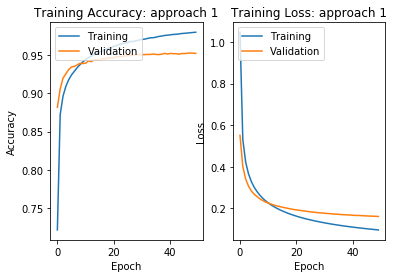

10000/10000 [==============================] - 0s 25us/step
loss: 0.191197
acc: 0.9433


In [108]:
plot_acc_and_score(history1,mlp1,"approach 1")

In [70]:
"""

4-Layer network of size [1024,  512,  256, 10]
4-Layer network of size [ 256,  512, 1024, 10]
"""


#2[1024 1024 10]
mlp2 = keras.models.Sequential()
mlp2.add(keras.layers.Dense(units=1024, activation="sigmoid", input_shape=(784,)))
mlp2.add(keras.layers.Dense(units=1024, activation="sigmoid"))
mlp2.add(keras.layers.Dense(units=10, activation="softmax"))
mlp2.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])


#3[1024 1024 1024 10]
mlp3 = keras.models.Sequential()
mlp3.add(keras.layers.Dense(units=1024, activation="sigmoid", input_shape=(784,)))
mlp3.add(keras.layers.Dense(units=1024, activation="sigmoid"))
mlp3.add(keras.layers.Dense(units=1024, activation="sigmoid"))
mlp3.add(keras.layers.Dense(units=10, activation="softmax"))
mlp3.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=["accuracy"])

#4 [1024,  512,  256, 10]
mlp4 = keras.models.Sequential()
mlp4.add(keras.layers.Dense(units=1024, activation="sigmoid", input_shape=(784,)))
mlp4.add(keras.layers.Dense(units=512, activation="sigmoid"))
mlp4.add(keras.layers.Dense(units=256, activation="sigmoid"))
mlp4.add(keras.layers.Dense(units=10, activation="softmax"))
mlp4.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=["accuracy"])

#5  [ 256,  512, 1024, 10]
mlp5 = keras.models.Sequential()
mlp5.add(keras.layers.Dense(units=256, activation="sigmoid", input_shape=(784,)))
mlp5.add(keras.layers.Dense(units=512, activation="sigmoid"))
mlp5.add(keras.layers.Dense(units=1024, activation="sigmoid"))
mlp5.add(keras.layers.Dense(units=10, activation="softmax"))
mlp5.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=["accuracy"])


         
         
         



In [71]:
print("approach 2 ")
history2 = mlp2.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)
print("approach 3 ")
history3 = mlp3.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)
print("approach 4 ")
history4 = mlp4.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)
print("approach 5 ")
history5 = mlp5.fit(x=X_flat_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 21us/step - loss: 2.0081 - acc: 0.5082 - val_loss: 1.6846 - val_acc: 0.7480
Epoch 2/50
54000/54000 [==============================] - 0s 7us/step - loss: 1.4823 - acc: 0.7612 - val_loss: 1.2430 - val_acc: 0.8227
Epoch 3/50
54000/54000 [==============================] - 0s 7us/step - loss: 1.1362 - acc: 0.8121 - val_loss: 0.9566 - val_acc: 0.8622
Epoch 4/50
54000/54000 [==============================] - 0s 7us/step - loss: 0.9140 - acc: 0.8363 - val_loss: 0.7750 - val_acc: 0.8808
Epoch 5/50
54000/54000 [==============================] - 0s 7us/step - loss: 0.7695 - acc: 0.8525 - val_loss: 0.6547 - val_acc: 0.8933
Epoch 6/50
54000/54000 [==============================] - 0s 7us/step - loss: 0.6711 - acc: 0.8647 - val_loss: 0.5720 - val_acc: 0.8973
Epoch 7/50
54000/54000 [==============================] - 0s 7us/step - loss: 0.6001 - acc: 0.8735 - val_loss: 0.5123 - val_acc: 0.904

54000/54000 [==============================] - 0s 6us/step - loss: 0.7224 - acc: 0.8523 - val_loss: 0.6505 - val_acc: 0.8858
Epoch 20/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.6821 - acc: 0.8584 - val_loss: 0.6124 - val_acc: 0.8902
Epoch 21/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.6463 - acc: 0.8639 - val_loss: 0.5788 - val_acc: 0.8920
Epoch 22/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.6144 - acc: 0.8678 - val_loss: 0.5487 - val_acc: 0.8957
Epoch 23/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.5859 - acc: 0.8723 - val_loss: 0.5222 - val_acc: 0.8973
Epoch 24/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.5602 - acc: 0.8759 - val_loss: 0.4991 - val_acc: 0.8987
Epoch 25/50
54000/54000 [==============================] - 0s 6us/step - loss: 0.5371 - acc: 0.8793 - val_loss: 0.4778 - val_acc: 0.9017
Epoch 26/50
54000/54000 [============================

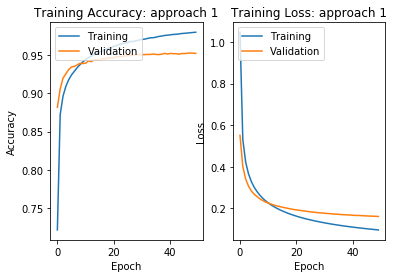

10000/10000 [==============================] - 0s 26us/step
loss: 0.191197
acc: 0.9433


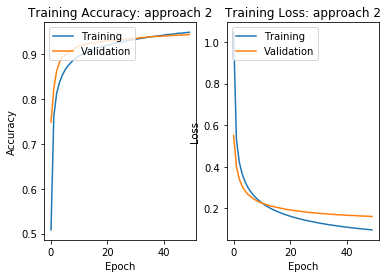

10000/10000 [==============================] - 0s 29us/step
loss: 0.238723
acc: 0.9296


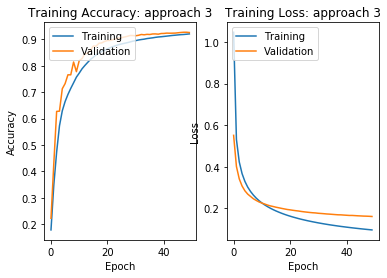

10000/10000 [==============================] - 0s 26us/step
loss: 0.309328
acc: 0.9117


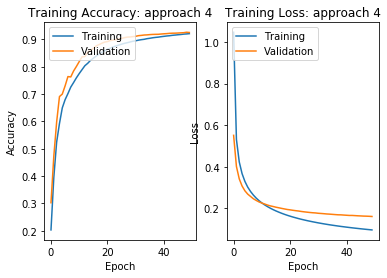

10000/10000 [==============================] - 0s 29us/step
loss: 0.317178
acc: 0.9135


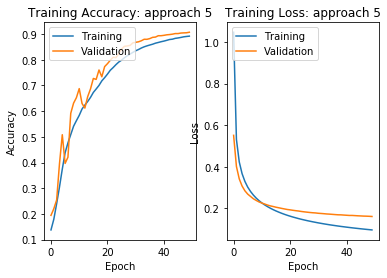

10000/10000 [==============================] - 0s 28us/step
loss: 0.428684
acc: 0.8887


In [109]:
plot_acc_and_score(history1,mlp1,"approach 1")
plot_acc_and_score(history2,mlp2,"approach 2")
plot_acc_and_score(history3,mlp3,"approach 3")
plot_acc_and_score(history4,mlp4,"approach 4")
plot_acc_and_score(history5,mlp5,"approach 5")